# Predicting heart disease using machine learning

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting whether or not someone has heart disease based on their medical attributes.

- [Preparing the tools](#preparing-the-tools)
- [Load Data](#load-data)
- [Data Exploration](#data-exploration)
  - [Heart Rate Disease Frequency according to sex](#heart-disease-frequency-according-to-sex)
- [Modelling](#modelling)
  - [Finding ideal model](#finding-ideal-model)
  - [Visual model comparison](#visual-model-comparison)
- [Tuning/Improving a model](#tuningimproving-a-model)
  - [KNN](#knn)
  - [Logistic Regression](#logistic-regression)
    - [LogisticRegression with RandomizedSearchCV](#logisticregression-with-randomizedsearchcv)
    - [LogisticRegression with GridSearchCV](#logisticregression-with-gridsearchcv)
  - [RandomForestClassifier](#randomforestclassifier)
    - [RandomForestClassifier with RandomizedSearchCV](#randomforestclassifier-with-randomizedsearchcv)
    - [RandomForestClassifier with GridSearchCV](#randomforestclassifier-with-gridsearchcv)
- [Evaluating tuned machine learning model beyond accuracy](#evaluating-tuned-machine-learning-model-beyond-accuracy)
  - [Calculate evaluation metrics using cross-validation](#calculate-evaluation-metrics-using-cross-validation)
- [Feature importance](#feature-importance)


## Preparing the tools

We're going to use pandas, Matplotlib and NumPy for data analysis and manipulation.


In [2]:
# Import all the tools we need

# Type hinting
from pandas import Series, DataFrame
from numpy import float16, float32, float64

# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Models for Scikit-Learn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Model Evaluation
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score

In [51]:
# Type Annotations
type classification_models = (
    LogisticRegression | KNeighborsClassifier | RandomForestClassifier
)

type floats = float | float16 | float32 | float64


## Load Data


In [4]:
csv_path: str = '../dataset/heart-disease.csv'
df: DataFrame = pd.read_csv(csv_path)
df.shape

(303, 14)

## Data Exploration

The goal here is to find out more about the data and become a subject matter expert on the dataset that is being worked on

1. What question(s) are you trying to solve
2. What kind of data do we have and how do we treat different types?
3. What's missing from the data and how do you deal with it?
4. Where are the outliers and why should you care about them?
5. How can you add, change or remove features to get more out of the data?


In [5]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [6]:
df.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


We get the target column and do some analysis on it, coming to the conclusion that this problem is a relatively balanced one, with a good amount of representations for each of the targets


In [7]:
df['target'].value_counts()

target
1    165
0    138
Name: count, dtype: int64

<Axes: xlabel='target'>

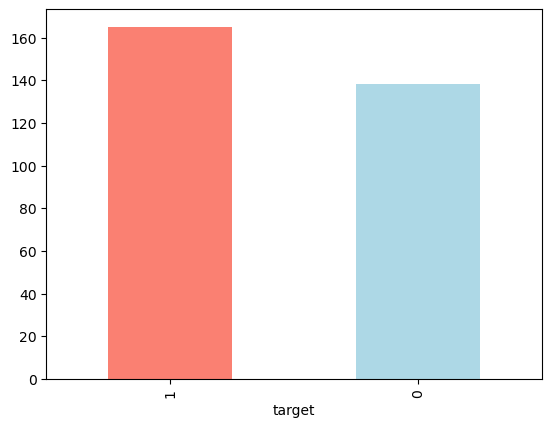

In [8]:
df['target'].value_counts().plot(kind='bar', color=['salmon', 'lightblue'])

Looking at other columns now, are there any values, what do these columns have in them


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Are there any missing values?


In [10]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [11]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


### Heart Disease Frequency according to Sex


In [12]:
df.sex.value_counts()

sex
1    207
0     96
Name: count, dtype: int64

When trying to build a good machine learning model, its important to find patterns in the data. Although this is what the model eventually does, doing this before creating the model might be important to guide the model in a better direction even before its been built.


In [13]:
# Compare target column with sex column
pd.crosstab(df.target, df.sex)

sex,0,1
target,,
0,24,114
1,72,93


Some insight, such as the proportion of women that present heart disease, might already indicate the behaviour of the model when the prediction is done in a woman. This is because, even though there are fewer samples of women, 75% of these samples have developed heart disease.


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

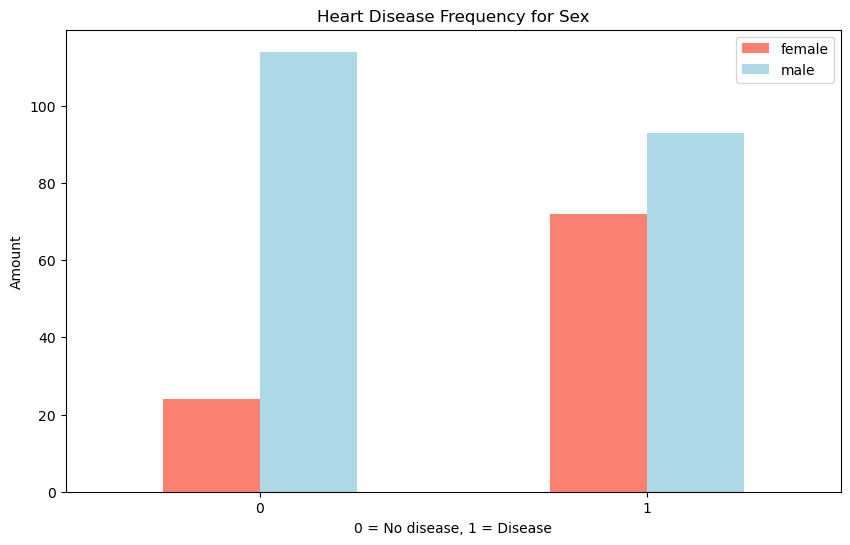

In [14]:
# Create a plot of crosstab
pd.crosstab(df.target, df.sex).plot(
    kind='bar', figsize=(10, 6), color=['salmon', 'lightblue']
)

plt.title('Heart Disease Frequency for Sex')
plt.xlabel('0 = No disease, 1 = Disease')
plt.ylabel('Amount')
plt.legend(['female', 'male'])
plt.xticks(rotation=0)

A more visual approach really sells how much the gap between male subjects with heart disease and female subjects with heart disease is bigger on the latter.


In [15]:
df['thalach'].value_counts()

thalach
162    11
160     9
163     9
152     8
173     8
       ..
202     1
184     1
121     1
192     1
90      1
Name: count, Length: 91, dtype: int64

It's important to note that some plots show some information better than other ones. For instance, when plotting something like the 'target' column, that has two distinct values, its feasible to use a bar plot, that will show two unique values. On the other hand, plotting 'thalach' may not be ideal in a bar plot, due to its 91 distinct values.


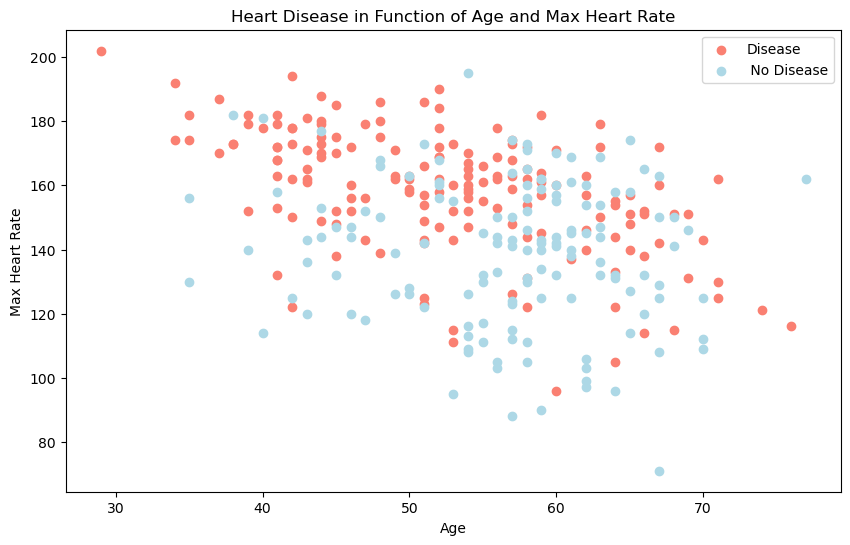

In [16]:
# Age vs Max Heart Rate for Heart Disease
plt.figure(figsize=(10, 6))

# Scatter with positive examples
plt.scatter(df.age[df.target == 1], df.thalach[df.target == 1], c='salmon')

# Scatter with negative examples
plt.scatter(df.age[df.target == 0], df.thalach[df.target == 0], c='lightblue')

# Customizing the plot
plt.title('Heart Disease in Function of Age and Max Heart Rate')
plt.xlabel('Age')
plt.ylabel('Max Heart Rate')
plt.legend(['Disease', ' No Disease'])

<Axes: ylabel='Frequency'>

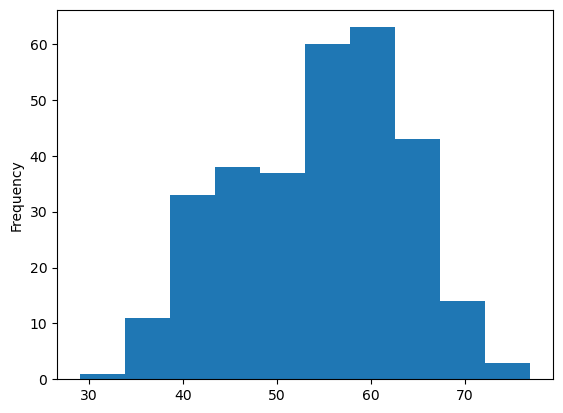

In [17]:
# Check the distribution of the age column with a histogram
df.age.plot.hist()

In [18]:
# Visualizing the heart disease frequency per chest pain type
pd.crosstab(df.cp, df.target)

target,0,1
cp,,
0,104,39
1,9,41
2,18,69
3,7,16


(array([0, 1, 2, 3]),
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

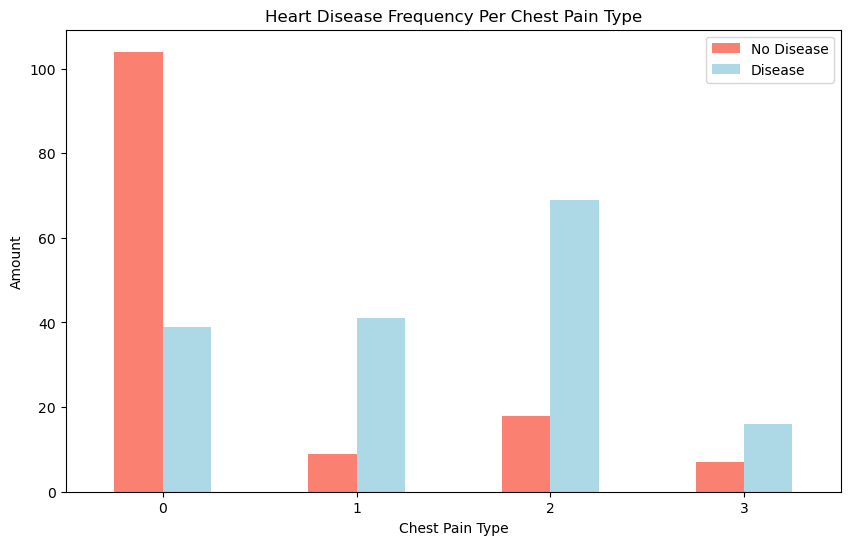

In [19]:
# Making crosstab more visual
pd.crosstab(df.cp, df.target).plot(
    kind='bar', figsize=(10, 6), color=['salmon', 'lightblue']
)

# Customizing plot
plt.title('Heart Disease Frequency Per Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.ylabel('Amount')
plt.legend(['No Disease', 'Disease'])
plt.xticks(rotation=0)

The whole idea of this step in the process is to gain some insight into the data that is being worked with, and the plot above, shows us in a very visual way how there is some sort of correlation between 'cp' type 2 and Heart Disease.

It's a good idea then, to build a correlation matrix.


In [20]:
# Creating a correlation matrix
df.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


In Layman's terms, a correlation matrix associates each of the metrics presented in the table with each other


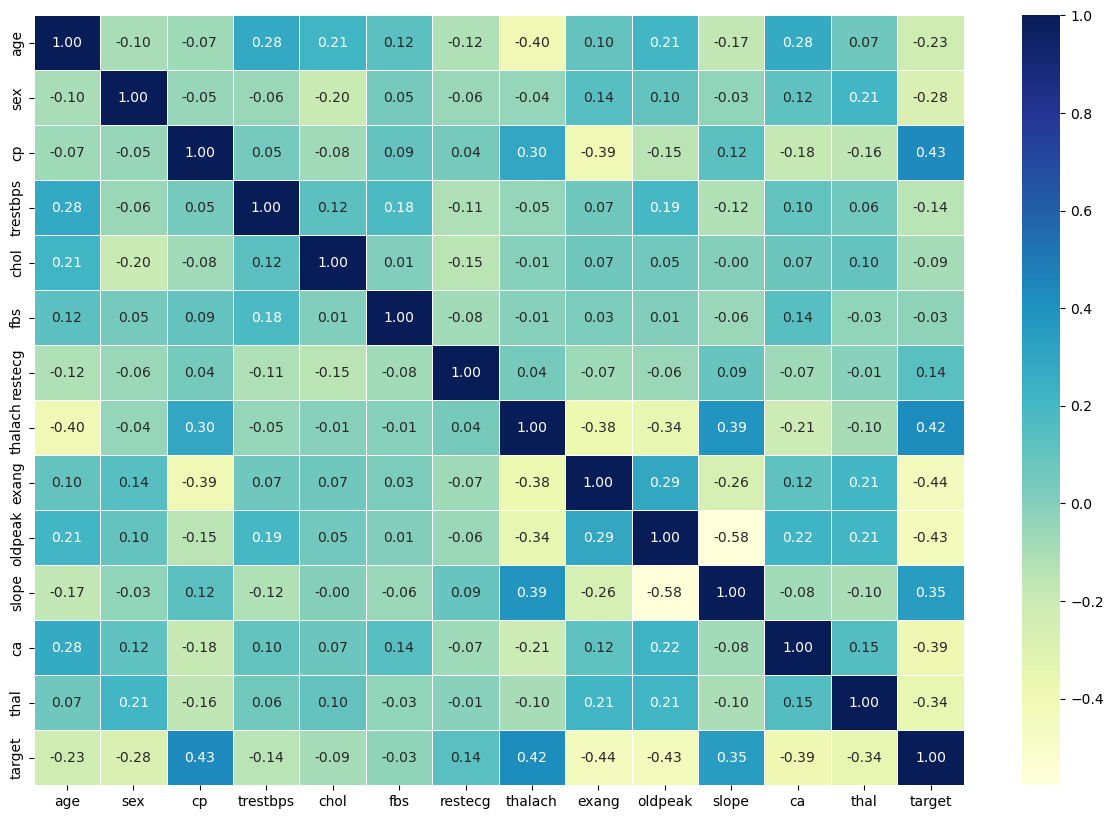

In [21]:
# Making correlation matrix more readable
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt='.2f', cmap='YlGnBu')

## Modelling


In [22]:
# Split the data into X and y (independent and dependent features)
X: DataFrame = df.drop('target', axis=1)
y: Series = df.target

In [23]:
# Split the data into train and test splits
np.random.seed(42)

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Once the data is split into training and test sets, it's time to build a Machine Learning model.

The model will train (find the patterns) on the training set, by investigating the features and analysing how they turn into the target.

The model will be tested (the patterns will be used) on the test set, once these patterns are found they are applied on data the model has never seen.


### Finding ideal model

The next logical step would be to find the ideal model for our data, we're going to try using 3 different machine learning models:

1. Logistic Regression
2. K-Nearest Neighbours Classifier
3. Random Forest Classifier


In [24]:
# Create a function to fit and score models


def fit_and_score(
    models: dict[str, classification_models],
    X_train: DataFrame,
    X_test: DataFrame,
    y_train: Series,
    y_test: Series,
) -> dict[str, floats]:
    '''
    Fits and evaluates given machine learning models.
    models: a dict of different Scikit-Learn machine learning models
    X_train: training data (no labels)
    X_test: testing data (no labels)
    y_train: training labels
    y_test: test labels
    '''

    # Setup random seed
    np.random.seed(42)

    # Model scores dictionary
    model_scores: dict[str, floats] = {}

    # Fitting and scoring models iteratively
    for name, model in models.items():
        # Fitting the model
        model.fit(X_train, y_train)
        # Scoring and saving the model's score
        model_scores[name] = model.score(X_test, y_test)

    return model_scores

In [25]:
# Putting models in dictionary

models: dict[str, classification_models] = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
}

In [26]:
#
models_scores = fit_and_score(
    models=models,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
)
models_scores

/Users/figredos/Developer/data_science/milestone-projects/classification/.env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Logistic Regression': 0.8852459016393442,
 'KNN': 0.6885245901639344,
 'Random Forest': 0.8360655737704918}

### Visual model comparison


<Axes: >

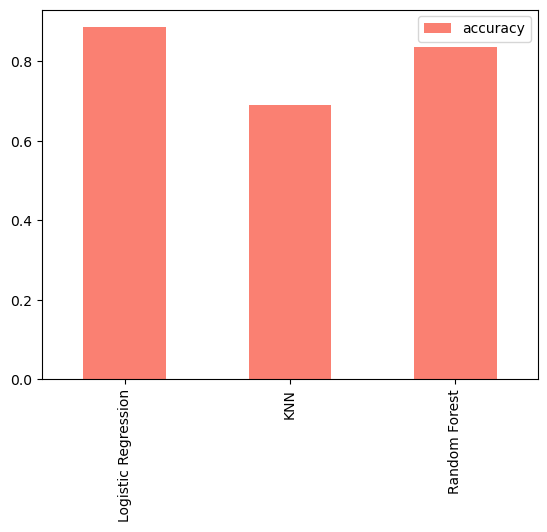

In [27]:
# Creating comparison plot
model_compare = pd.DataFrame(models_scores, index=['accuracy'])
model_compare.T.plot.bar(color=['salmon'])

## Tuning/Improving a model

Now, we've got a baseline model... and we know a model's first predictions aren't always what we should base our next steps off.

Let's look at the following:

- Hyperparameter tuning
- Feature importance
- Confusion Matrix
- Cross-validation
- Precision
- Recall
- F1 score
- Classification report
- ROC curve
- Area under the curve (AUC)


### KNN


In [28]:
# Tuning Knn
train_scores: list = []
test_scores: list = []

# Creating a list of different values for n_neighbors
neighbors: range = range(1, 21)

# Setup KNN instance
knn: KNeighborsClassifier = KNeighborsClassifier()

# Loop through different n_neighbors
for i in neighbors:
    knn.set_params(n_neighbors=i)

    # Fit the algorithm
    knn.fit(X_train, y_train)

    # Update the training scores list
    train_scores.append(knn.score(X_train, y_train))

    # Update the test scores list
    test_scores.append(knn.score(X_test, y_test))

Maximum KNN score on the test data: 75.41%


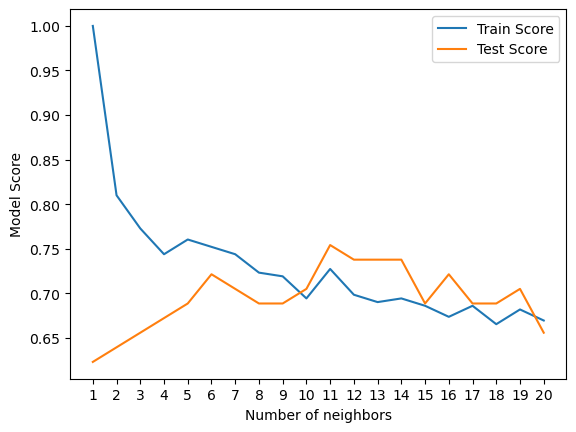

In [29]:
# Visualizing scores
plt.plot(neighbors, train_scores, label='Train Score')
plt.plot(neighbors, test_scores, label='Test Score')

plt.xticks(np.arange(1, 21, 1))

plt.xlabel('Number of neighbors')
plt.ylabel('Model Score')
plt.legend()

print(f'Maximum KNN score on the test data: {max(test_scores)*100:.2f}%')

As seen previously and now shown by the small tweak on KNN's `n_neighbors` parameter, this model is far from our desired 95% accuracy presented in the proof of concept for this project. Therefore, from now on, this model type won't be used.


### LogisticRegression


#### LogisticRegression with RandomizedSearchCV

We're going to tune the Logistic Regression model using RandomizedSearchCV.


In [30]:
# Creating a hyperparameter grid for LogisticRegression
log_reg_grid = {
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear'],
}

In [31]:
# Tuning LogisticRegression

# Setting up random seed
np.random.seed(42)

# Setup random hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(
    LogisticRegression(),
    param_distributions=log_reg_grid,
    cv=5,
    n_iter=20,
    verbose=True,
)

# Fit random hyperparameter search model for LogisticRegression
rs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [32]:
# Check best parameters
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 0.23357214690901212}

In [33]:
# Scoring model
rs_log_reg.score(X_test, y_test)

0.8852459016393442

#### LogisticRegression with GridSearchCV

Now, we're going to tune the LogisticRegression model with GridSearchCV


In [34]:
# Creating different Hyperparameters
log_reg_grid = {
    'C': np.logspace(-4, 4, 30),
    'solver': ['liblinear'],
}

# Setup grid hyperparameter search
gs_log_reg = GridSearchCV(
    LogisticRegression(),
    param_grid=log_reg_grid,
    cv=5,
    verbose=True,
)

# Fit grid hyperparameter search model
gs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'solver': ['liblinear']},
             verbose=True)

In [35]:
# Check the best hyperparameters
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [36]:
# Scoring the model
gs_log_reg.score(X_test, y_test)

0.8852459016393442

### RandomForestClassifier


In [37]:
# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {
    'n_estimators': np.arange(10, 1000, 50),
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': np.arange(2, 20, 2),
    'min_samples_leaf': np.arange(1, 20, 2),
}

#### RandomForestClassifier with RandomizedSearchCV

We're going to tune the RandomForestClassifier with RandomizedSearchCV


In [38]:
# Tuning RandomForestClassifier

# Setting up random seed
np.random.seed(42)

# Setting up hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(
    RandomForestClassifier(),
    param_distributions=rf_grid,
    cv=5,
    n_iter=20,
    verbose=True,
)

# Fit random hyperparameter search model for RandomForestClassifier
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [39]:
# Finding best parameters
rs_rf.best_params_

{'n_estimators': 210,
 'min_samples_split': 4,
 'min_samples_leaf': 19,
 'max_depth': 3}

In [40]:
# Scoring model
rs_rf.score(X_test, y_test)

0.8688524590163934

#### RandomForestClassifier with GridSearchCV

Now, we're going to tune the LogisticRegression model with GridSearchCV


In [ ]:
# Setting up GridSearchCV model
gs_rf = GridSearchCV(
    RandomForestClassifier(), param_grid=rf_grid, cv=5, verbose=2, n_jobs=-1
)

# Fitting GS model
gs_rf.fit(X_train, y_train)

In [ ]:
# Finding best parameters
gs_rf.best_params_

{'max_depth': None,
 'min_samples_leaf': 11,
 'min_samples_split': 4,
 'n_estimators': 10}

In [ ]:
# Scoring model
gs_rf.score(X_test, y_test)

0.8524590163934426

### Conclusion

Even running the RandomForest model with GridSearchCv, we couldn't find a better model, in fact, it performed a little bit worse than the RandomizedSearchCV model. Therefore, from now on, the chosen model will be LinearRegression.


## Evaluating tuned machine learning model, beyond accuracy

- ROC curve and AUC curve
- Confusion matrix
- Classification report
- Precision
- Recall
- F1-score

It would be great if cross-validation was used where possible.

To make comparisons and evaluate our trained model, first we need to make predictions.


In [ ]:
# Make predictions with tuned model
y_preds: np.ndarray = gs_log_reg.predict(X_test)

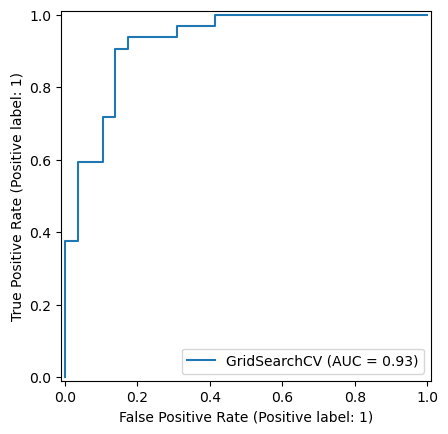

In [ ]:
# Plot ROC curve and calculate the AUC metric
RocCurveDisplay.from_estimator(gs_log_reg, X_test, y_test)

In [ ]:
# Creating a confusion matrix
print(confusion_matrix(y_test, y_preds))

[[25  4]
 [ 3 29]]


In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_test: Series, y_preds: np.ndarray):
    '''
    Plots a nice looking confusion matrix using Seaborn's heatmap()
    '''
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(
        confusion_matrix(y_test, y_preds),
        annot=True,
        cbar=False,
    )

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

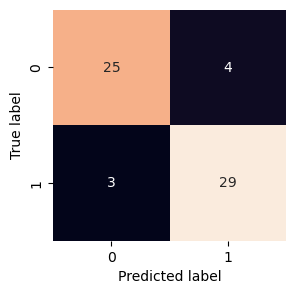

In [ ]:
# Plotting confusion matrix
plot_confusion_matrix(y_test, y_preds)

Now we've got a ROC curve, an AUC metric and a confusion matrix, let's get a classification report as well as cross-validated precision, recall and f1-score.


In [ ]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



### Calculate evaluation metrics using cross-validation

The next step would be to calculate some of the metrics found in the classification report using cross-validation. Metrics such as precision, recall, f1-score.


In [42]:
# Checking best parameters
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [62]:
# Create a new classifier with best parameters
clf = LogisticRegression(
    C=0.20433597178569418,
    solver='liblinear',
)

clf.fit(X_train, y_train)

LogisticRegression(C=0.20433597178569418, solver='liblinear')

In [63]:
# Creating function to calculate the mean of metrics
def mean_evaluation(
    clf: LogisticRegression,
    X: DataFrame,
    y: Series,
    cv: int,
    scoring: list[str],
) -> pd.DataFrame:

    evaluation_dict: dict[str, float64] = {}

    for evaluator in scoring:
        evaluation_dict[evaluator] = np.mean(
            cross_val_score(
                estimator=clf,
                X=X,
                y=y,
                cv=cv,
                scoring=evaluator,
            )
        )

    return pd.DataFrame(evaluation_dict, index=[0])

In [64]:
# Creating DataFrame
cv_metrics = mean_evaluation(clf, X, y, 5, ['accuracy', 'precision', 'recall', 'f1'])
cv_metrics

,accuracy,precision,recall,f1
0,0.844699,0.820794,0.921212,0.867301


<Axes: title={'center': 'Cross-validated classification metrics'}>

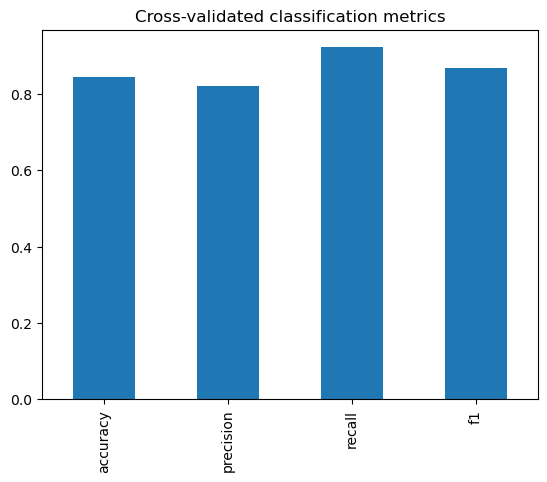

In [65]:
# Plotting metrics DataFrame
cv_metrics.T.plot.bar(title='Cross-validated classification metrics', legend=False)

## Feature importance

Feature importance is another way of asking, "which features contributed most to the outcomes of the model and how did they contribute?".

Finding feature importance is different for each machine learning model.


In [66]:
# Check coef_
clf.coef_

array([[ 0.00316728, -0.8604465 ,  0.66067041, -0.01156993, -0.00166374,
         0.04386107,  0.31275846,  0.02459361, -0.60413079, -0.56862804,
         0.45051628, -0.63609897, -0.67663372]])

In [67]:
# matching coef's of features to columns
feature_dict = dict(zip(df.columns, list(clf.coef_[0])))
feature_dict

{'age': 0.0031672800489608455,
 'sex': -0.8604464974271708,
 'cp': 0.6606704082728109,
 'trestbps': -0.01156993196274824,
 'chol': -0.0016637440923087717,
 'fbs': 0.04386107313075342,
 'restecg': 0.3127584615862929,
 'thalach': 0.02459361332045646,
 'exang': -0.6041307948760266,
 'oldpeak': -0.568628039197438,
 'slope': 0.4505162753782247,
 'ca': -0.636098965095586,
 'thal': -0.6766337239240338}

<Axes: title={'center': 'Feature Importance'}>

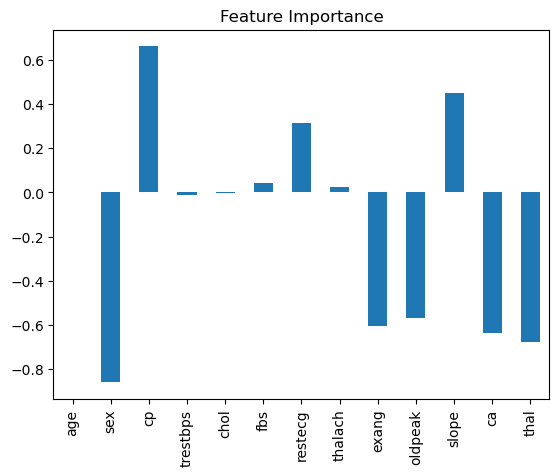

In [68]:
# Visualize feature importance
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title='Feature Importance', legend=False)